In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


### Download sequences

In [2]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    666      0 --:--:-- --:--:-- --:--:--   666
100 35.4M  100 35.4M    0     0  4786k      0  0:00:07  0:00:07 --:--:-- 7734k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    737      0 --:--:-- --:--:-- --:--:--   737
100 13.7M  100 13.7M    0     0  7610k      0  0:00:01  0:00:01 --:--:-- 15.4M
+ bash scripts/

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [4]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [5]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [6]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [7]:
df.reason.value_counts()

N                             294356
X                             210046
A[B.1.1.7]                     35832
A[B.1.617.2]                   35433
Y                              25134
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [8]:
import re

In [9]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    x = pd.crosstab(d.lineage.cat.remove_unused_categories() == "None", d.sequencing_pc).T
    #print((x[True] / x.sum(1)).sort_values())
    print(x)

lineage        False  True 
sequencing_pc              
1127.0            74      0
12489.0           55      0
1307.0          1123      2
13353.0          844      0
14467.0         2176      3
1458.0           924     13
16321.0         3737      9
17475.0         1303      6
20095.0         3736      6
20251.0          994      0
21502.0        11420     54
22081.0         2662      8
23845.0          203      0
30159.0         8568     12
30167.0           59      0
30449.0           52      0
3048.0           256      3
32105.0         1169      6
32545.0          669      2
32758.0          137      0
37075.0          156      0
40210.0         2593     13
40225.0         3675     13
40477.0         1582      5
4103.0          1283     12
44137.0         7578      1
44879.0         4013    108
45147.0          288      3
4779.0         33671    233
50858.0        18546     60
50933.0         1926     38
55128.0            4      0
55131.0          927     22
66123.0         1220

In [10]:
import re
d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")

IMS_ID
IMS-10294-CVDP-87A74412-A73F-4B65-AA1B-1D2F60BAD700    False
IMS-10294-CVDP-307E544A-42F4-487F-A925-D7A6E5A3D20E    False
IMS-10294-CVDP-7E903449-A7EF-4A04-8A14-278C1D6C6E68    False
IMS-10294-CVDP-59FB4C41-BD0E-48BC-AC35-73356B52044A    False
IMS-10294-CVDP-1A233FB2-B135-4F49-BFDF-AE612E2E9BF7    False
                                                       ...  
IMS-10280-CVDP-E41BA432-F07E-4CF5-9B68-C8DF8FA5EF95    False
IMS-10280-CVDP-C42370E6-0751-4920-9316-F576D5460864    False
IMS-10280-CVDP-DF4B817C-5D28-48C1-9A5A-548768912F29    False
IMS-10280-CVDP-4B2F46B9-2BF1-44BE-8204-FEDC020940DA    False
IMS-10280-CVDP-254A4EF3-4576-46A6-8A24-3F676EE0A3BE    False
Name: lineage, Length: 249293, dtype: bool

In [11]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-02-22     2       2     3     0      0          0
                  2022-02-23     0       0     3     0      0          0
                  2022-02-24     0       0     0     0      0          0
                  2022-02-25     0       0     0     0      0          0
                  2022-02-28     0       0     0     0      0          0

[1888 rows x 6 columns]

In [12]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland                                                         
Baden-Württemberg       15438   16059  5920     4     23      41411
Bayern                   2193    2816  1068     0     29       6199
Berlin                    661     617   525     0      5       2888
Brandenburg               870    1168   450     1      0       2851
Bremen                    175     264     1     0      5        837
Hamburg                  3790    3023   756     3     23       3766
Hessen                    928    1370   317     2      1       1642
Mecklenburg-Vorpommern    513     445   221     0      0       2824
Niedersachsen             889     940   361     0      6       3018
Nordrhein-Westfalen     17499   17478  5394    12     71      26426
Rheinland-Pfalz           258     179    35     0      2       1509
Saarland                  659     856    87     0      4       1776
Sachsen                  4530    6057  1646     2     30      15053
Sachsen-Anhalt           1622     476   687     3      0       3003
Schleswig-Holstein       3074    4084  1753     4      2       3907
Thüringen                 280     447    89     0      8       1702

In [13]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [14]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [15]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [16]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A05-A14      W          2022-03-02  2022-03-02   
            A15-A34      W          2022-03-02  2022-03-02   
            A35-A59      W          2022-03-02  2022-03-02   
            A60-A79      W          2022-03-02  2022-03-02   
            A80+         W          2022-03-02  2022-03-02   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A05-A14      W          2022-03-02                     0   
            A15-A34      W          2022-03-02                     0   
            A35-A59      W          2022-03-02                     0   
            A60-A79      W          2022-03-02                     0   
            A80+         W          2022-03-02                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A05-A14      W          2022-03-02          1              -9   
            A15-A34      W          2022-03-02          1              -9   
            A35-A59      W          2022-03-02          1              -9   
            A60-A79      W          2022-03-02          1              -9   
            A80+         W          2022-03-02          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A05-A14      W          2022-03-02          -9          17   
            A15-A34      W          2022-03-02          -9          28   
            A35-A59      W          2022-03-02          -9          35   
            A60-A79      W          2022-03-02          -9          17   
            A80+         W          2022-03-02          -9           5   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

In [71]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

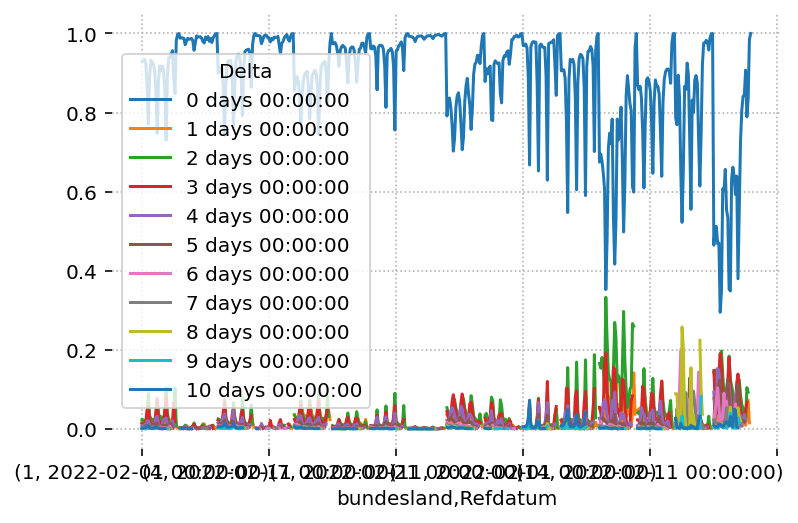

In [72]:
f.plot()

In [73]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [74]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [75]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.943112         0.957078         0.971235         0.985146   
Wed             0.940437         0.947737         0.971002         0.981231   
Thu             0.930610         0.950963         0.967045         0.972340   
Fri             0.923830         0.938499         0.948345         0.967643   
Sat             0.865828         0.877297         0.916205         0.965814   
Sun             0.773874         0.808449         0.901714         0.958705   
Mon             0.911175         0.934862         0.965727         0.975898   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.990539         0.992203         0.995387         0.997078   
Wed             0.984379         0.990487         0.995523         0.997536   
Thu             0.983843         0.993163         0.995937         0.996965   
Fri             0.984452         0.992598         0.993917         0.996666   
Sat             0.985720         0.988044         0.992056         0.993264   
Sun             0.971257         0.982311         0.987371         0.988512   
Mon             0.987134         0.991443         0.992797         0.995492   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.998223         0.998476               1.0  
Wed             0.997956         0.998880               1.0  
Thu             0.998309         0.997452               1.0  
Fri             0.996570         0.997623               1.0  
Sat             0.994888         0.995740               1.0  
Sun             0.993332         0.995416               1.0  
Mon             0.997491         0.998743               1.0

In [76]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [77]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [78]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999718  0.999768  0.999608  0.999180  0.998292   
Bayern                  0.996651  0.995436  0.992676  0.983809  0.968555   
Berlin                  0.996938  0.996207  0.995071  0.991933  0.967153   
Brandenburg             0.993707  0.993209  0.991277  0.987241  0.969171   
Bremen                  1.000000  0.999673  0.999522  0.999147  0.995715   
Hamburg                 0.998853  0.999402  0.998957  0.997977  0.995675   
Hessen                  0.999473  0.999194  0.998652  0.997438  0.993976   
Mecklenburg-Vorpommern  0.997572  0.997574  0.994176  0.991429  0.981528   
Niedersachsen           0.995683  0.994398  0.992386  0.987541  0.972319   
Nordrhein-Westfalen     0.996536  0.996370  0.994777  0.991512  0.982939   
Rheinland-Pfalz         0.999108  0.998747  0.998098  0.996359  0.987877   
Saarland                0.997768  0.998547  0.998331  0.996463  0.992380   
Sachsen                 0.998800  0.997697  0.996966  0.993057  0.981891   
Sachsen-Anhalt          0.989689  0.969515  0.982988  0.941580  0.825947   
Schleswig-Holstein      0.998223  0.997536  0.995937  0.992598  0.985720   
Thüringen               0.990124  0.986960  0.958189  0.900501  0.878932   

                               5         6         7         8  
Baden-Württemberg       0.996393  0.996209  0.995981  0.995364  
Bayern                  0.937102  0.906865  0.892295  0.892092  
Berlin                  0.879730  0.984880  0.982354  0.978857  
Brandenburg             0.904247  0.962291  0.957283  0.947986  
Bremen                  0.993263  0.994656  0.992765  0.993811  
Hamburg                 0.994754  0.994751  0.991503  0.991788  
Hessen                  0.983348  0.983188  0.980621  0.974509  
Mecklenburg-Vorpommern  0.924018  0.905215  0.838050  0.813450  
Niedersachsen           0.933250  0.948737  0.950695  0.946885  
Nordrhein-Westfalen     0.956586  0.954916  0.935306  0.920664  
Rheinland-Pfalz         0.956456  0.981951  0.974437  0.971555  
Saarland                0.969452  0.949364  0.958252  0.953954  
Sachsen                 0.951086  0.947887  0.935114  0.903123  
Sachsen-Anhalt          0.730648  0.839174  0.880381  0.897175  
Schleswig-Holstein      0.958705  0.965727  0.957078  0.940437  
Thüringen               0.779816  0.756115  0.739428  0.716217

In [79]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [80]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2142        2947        4426        4622   
Bayern                        5944        7032        9173        8946   
Berlin                        1325        1321        1442        1433   
Brandenburg                    809         980        1070        1061   
Bremen                          79          89          69          62   
Hamburg                        318         439         540         526   
Hessen                        1193        1594        1706        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1452        1674        1369   
Nordrhein-Westfalen           2496        3356        4256        4371   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2839        3669        3474        3311   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1820        1429        1424        1513   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5070        4126        2275        4379   
Bayern                        9244        8797        7224        9335   
Berlin                        1449         966         752        2169   
Brandenburg                   1183        1117         972        1254   
Bremen                          55          55          31          60   
Hamburg                        560         467         411         470   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4067        3725        2859        4333   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3469        3191        2661        4434   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         298         448   
Thüringen                     1430        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-21  2022-02-22  \
bundesland                                      ...                           
Baden-Württemberg             7112        7747  ...       21040       33156   
Bayern                       11242       12141  ...       26119       40950   
Berlin                        1917        2391  ...        8616        8352   
Brandenburg                   1493        1684  ...        5487        7751   
Bremen                         143          95  ...         701         722   
Hamburg                        534         577  ...        2201        2595   
Hessen                        1791        2067  ...        7373       12922   
Mecklenburg-Vorpommern         597         468  ...        2069        5436   
Niedersachsen                 1754        2164  ...       10729       19770   
Nordrhein-Westfalen           5253        5420  ...       27264       38099   
Rheinland-Pfalz               1139        1329  ...        7869        8708   
Saarland                       273         301  ...         911        2351   
Sachsen                       5756        5977  ...        7811       10064   
Sachsen-Anhalt                1019        1178  ...        4518        6729   
Schleswig-Holstein             486         542  ...        3714       

In [81]:
cases_land.sum(0)

Refdatum
2021-11-01     22322
2021-11-02     27096
2021-11-03     32076
2021-11-04     31506
2021-11-05     32536
               ...  
2022-02-26    104238
2022-02-27     55056
2022-02-28    118085
2022-03-01    171402
2022-03-02    140760
Length: 122, dtype: int64

In [82]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2142        2947        4426        4622   
Bayern                        5944        7032        9173        8946   
Berlin                        1325        1321        1442        1433   
Brandenburg                    809         980        1070        1061   
Bremen                          79          89          69          62   
Hamburg                        318         439         540         526   
Hessen                        1193        1594        1706        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1452        1674        1369   
Nordrhein-Westfalen           2496        3356        4256        4371   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2839        3669        3474        3311   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1820        1429        1424        1513   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5070        4126        2275        4379   
Bayern                        9244        8797        7224        9335   
Berlin                        1449         966         752        2169   
Brandenburg                   1183        1117         972        1254   
Bremen                          55          55          31          60   
Hamburg                        560         467         411         470   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4067        3725        2859        4333   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3469        3191        2661        4434   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         298         448   
Thüringen                     1430        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-20  2022-02-21  \
bundesland                                      ...                           
Baden-Württemberg             7112        7747  ...       12769       21040   
Bayern                       11242       12141  ...       20081       26119   
Berlin                        1917        2391  ...         601        8616   
Brandenburg                   1493        1684  ...        1193        5487   
Bremen                         143          95  ...         426         701   
Hamburg                        534         577  ...         960        2201   
Hessen                        1791        2067  ...        4397        7373   
Mecklenburg-Vorpommern         597         468  ...        1273        2069   
Niedersachsen                 1754        2164  ...        5232       10729   
Nordrhein-Westfalen           5253        5420  ...       12340       27264   
Rheinland-Pfalz               1139        1329  ...        1657        7869   
Saarland                       273         301  ...         768         911   
Sachsen                       5756        5977  ...        3703        7811   
Sachsen-Anhalt                1019        1178  ...        2683        4518   
Schleswig-Holstein             486         542  ...        1395       

In [83]:
C = cases_land.values

In [84]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [85]:
from genomicsurveillance.misc import fused_basis
B0 = fused_basis(C.shape[1]+clip, inc=10, fuse=5) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 

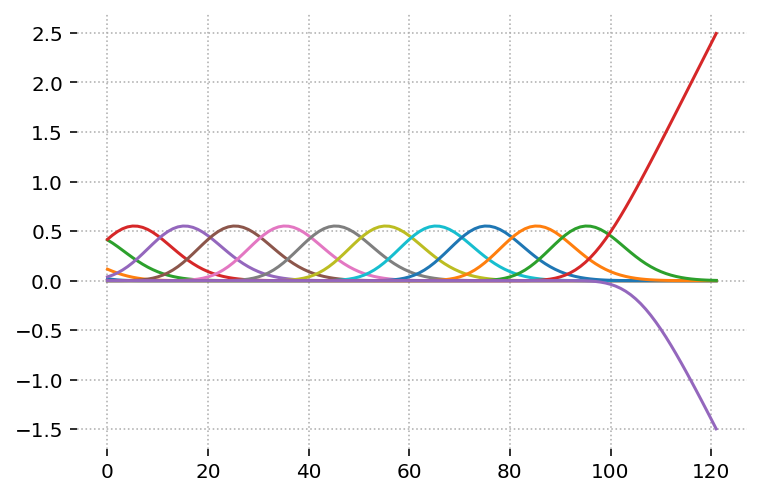

In [86]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

In [87]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [88]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [89]:
from numpyro.infer import Trace_ELBO

In [90]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

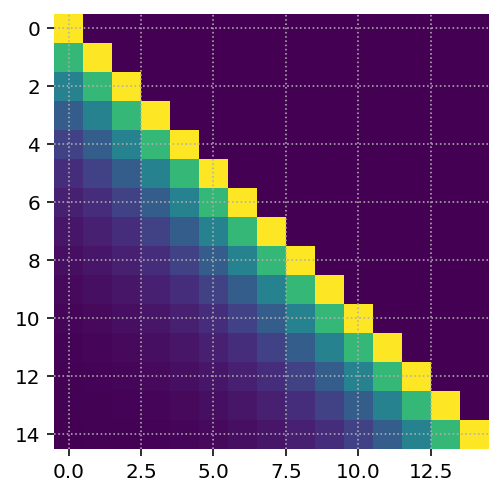

In [91]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

In [92]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':15000, 'lr':0.005, 'lrd': 0.2 ** (1/10000), 'num_samples': 100}

)

In [93]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 15,000 | 0 %
SVI step 1,000 / 15,000 | 7 %
SVI step 2,000 / 15,000 | 13 %
SVI step 3,000 / 15,000 | 20 %
SVI step 4,000 / 15,000 | 27 %
SVI step 5,000 / 15,000 | 33 %
SVI step 6,000 / 15,000 | 40 %
SVI step 7,000 / 15,000 | 47 %
SVI step 8,000 / 15,000 | 53 %
SVI step 9,000 / 15,000 | 60 %
SVI step 10,000 / 15,000 | 67 %
SVI step 11,000 / 15,000 | 73 %
SVI step 12,000 / 15,000 | 80 %
SVI step 13,000 / 15,000 | 87 %
SVI step 14,000 / 15,000 | 93 %


Text(0, 0.5, 'ELBO')

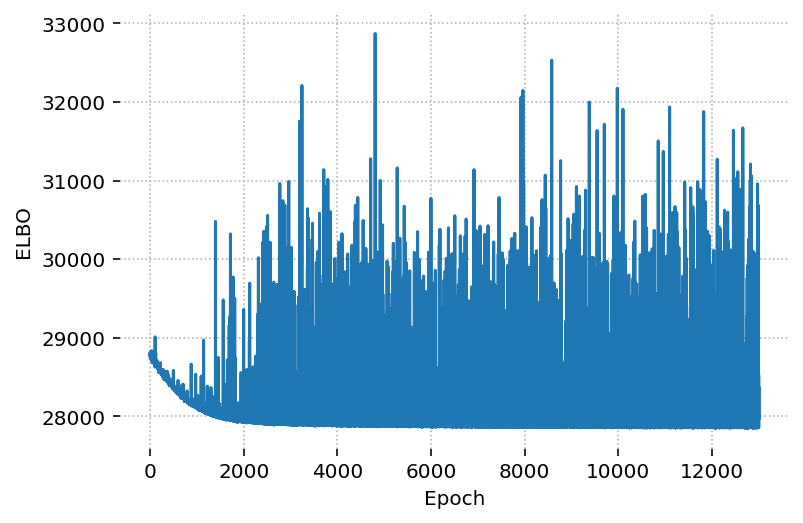

In [94]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

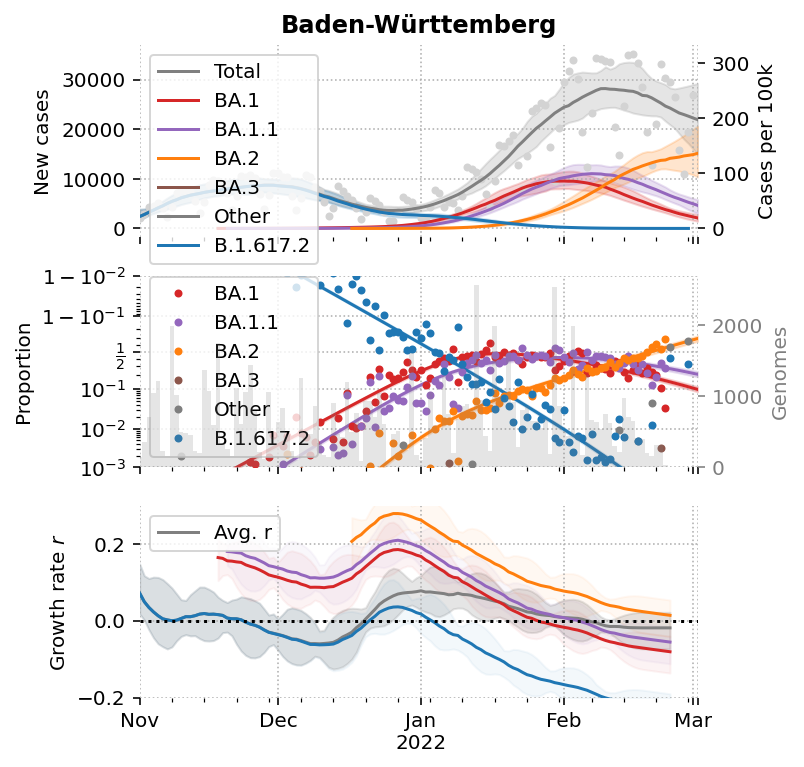

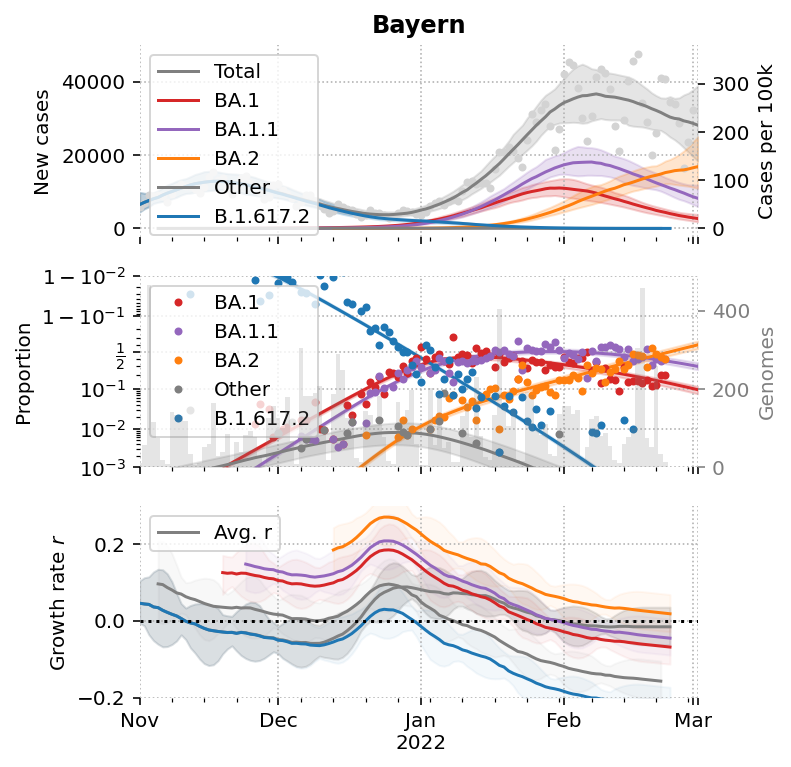

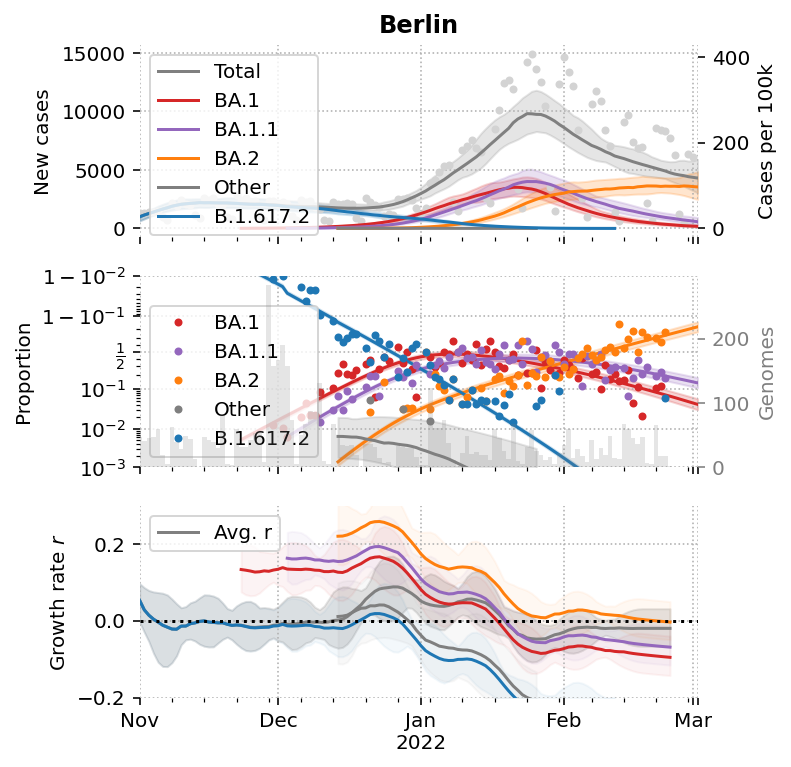

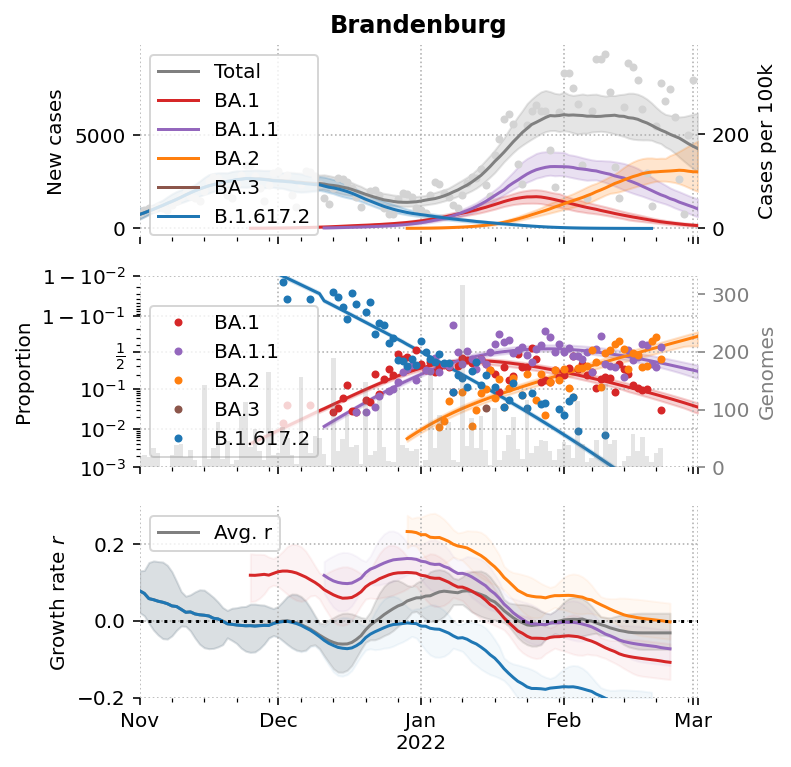

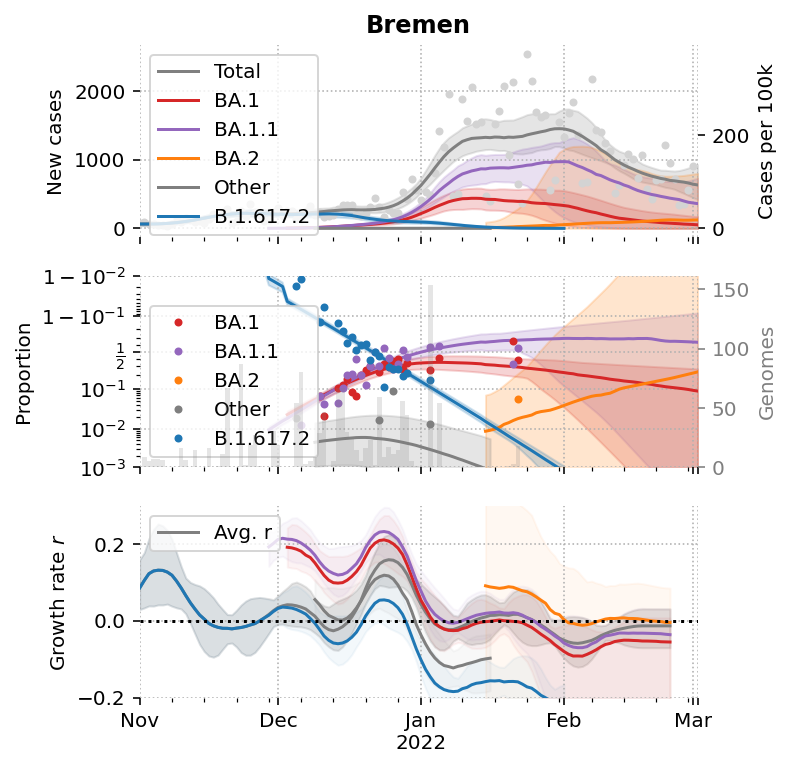

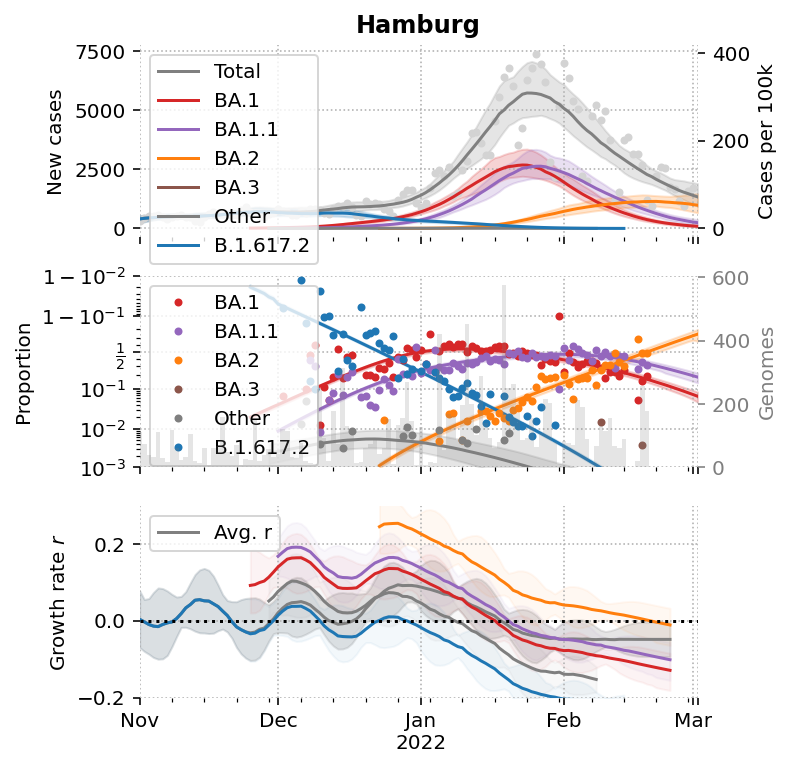

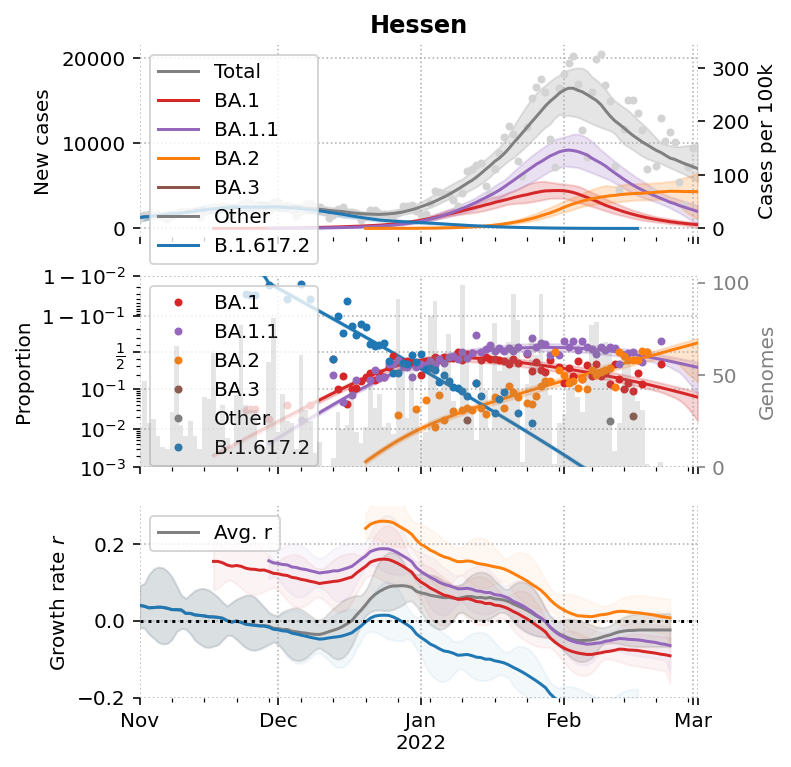

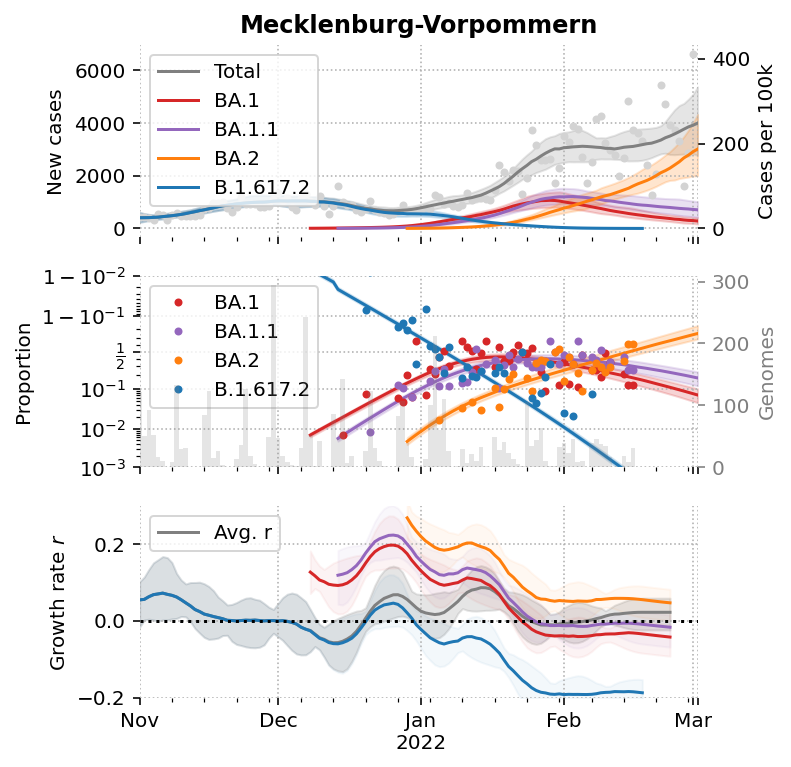

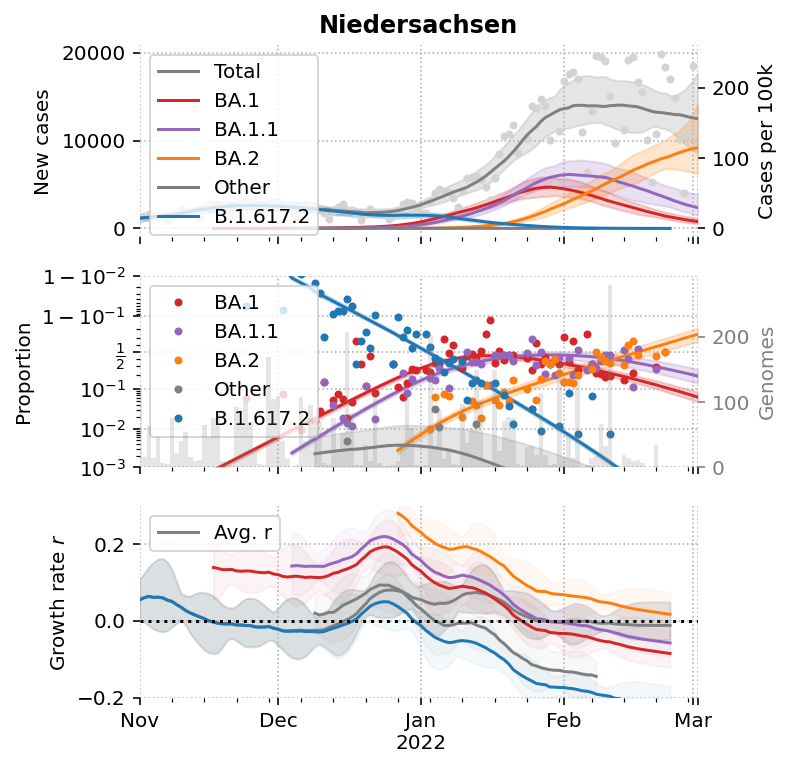

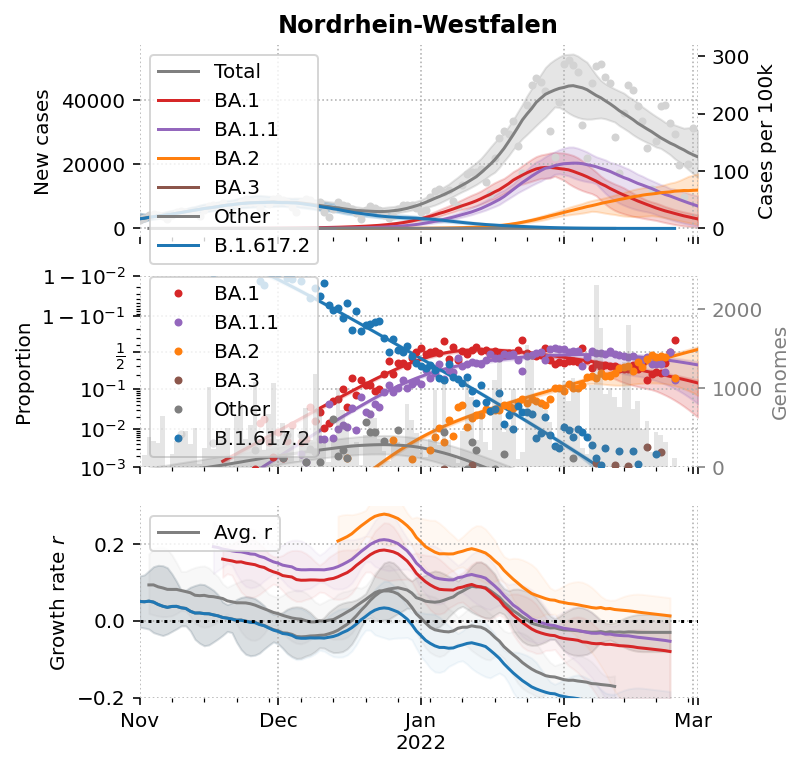

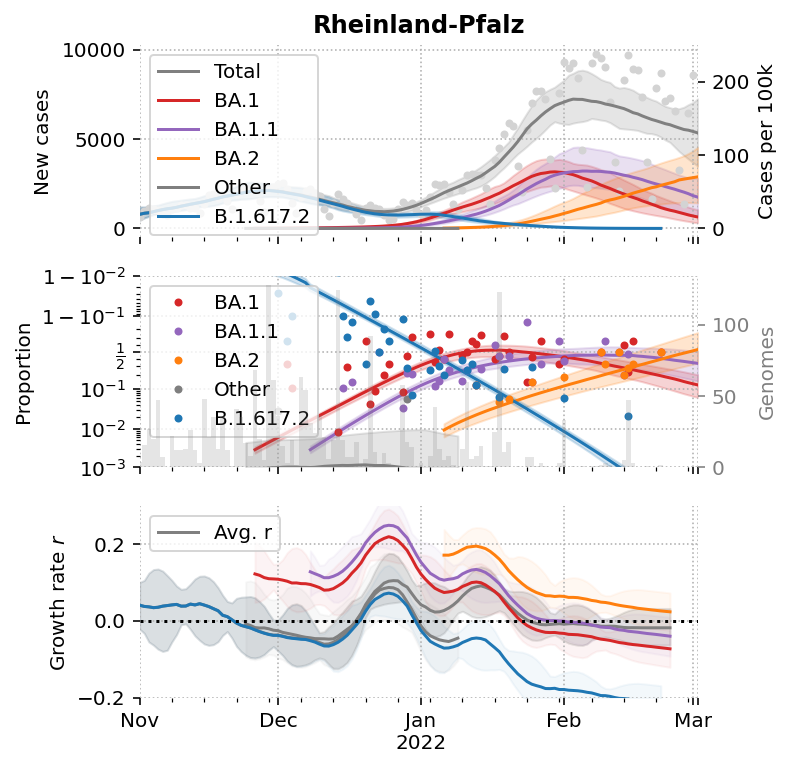

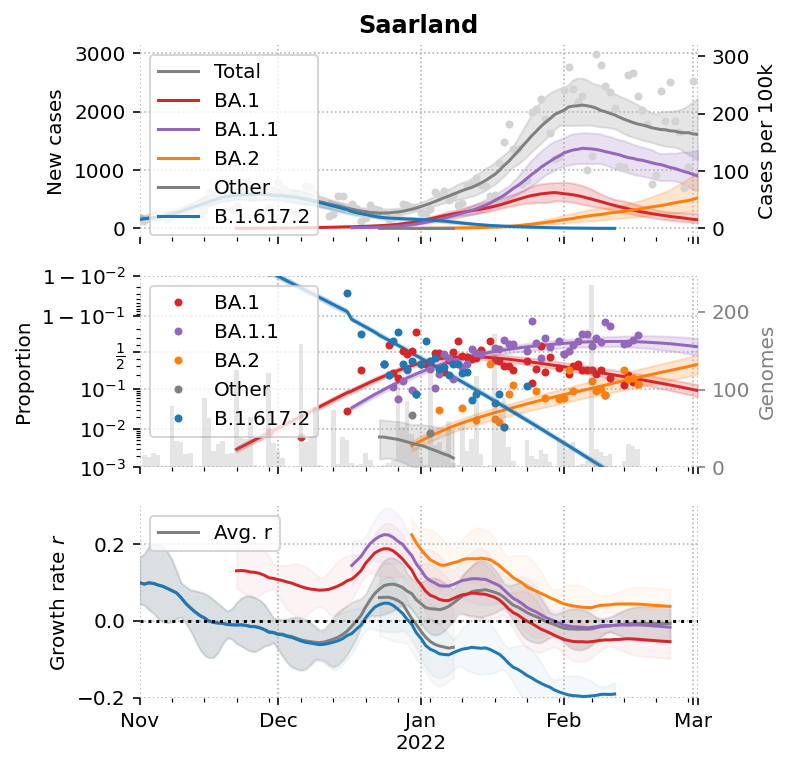

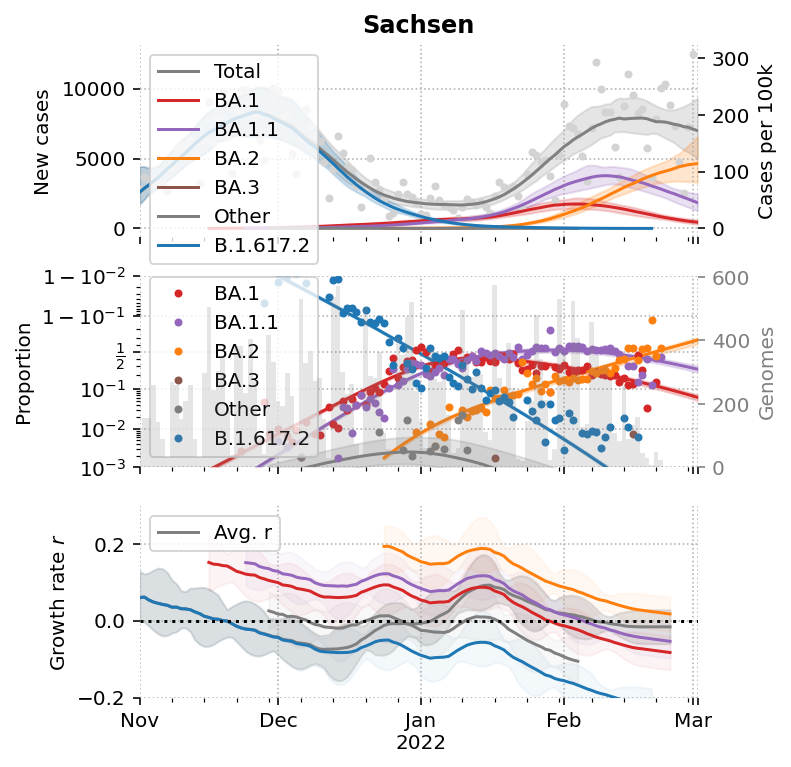

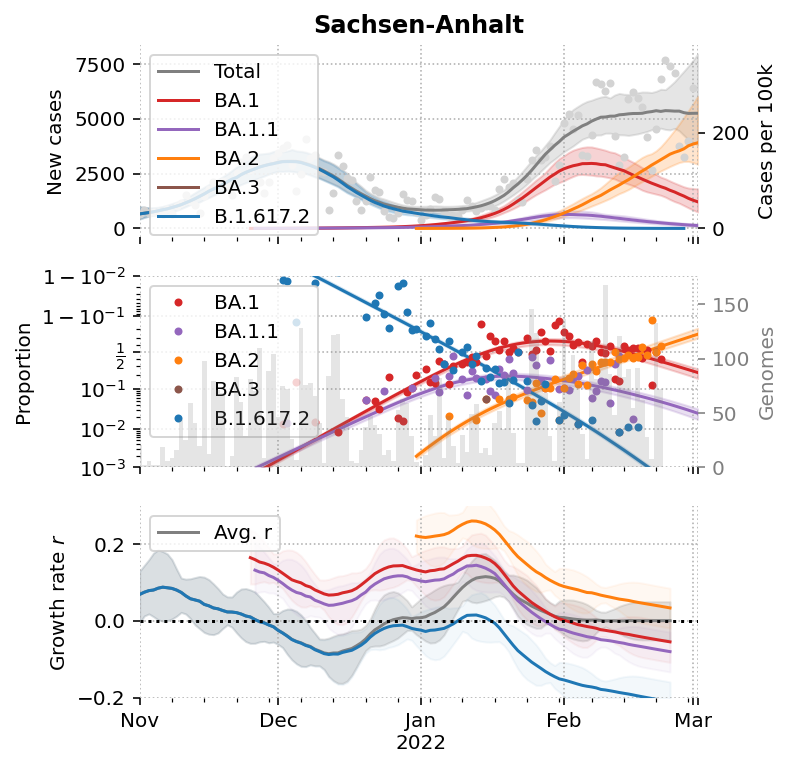

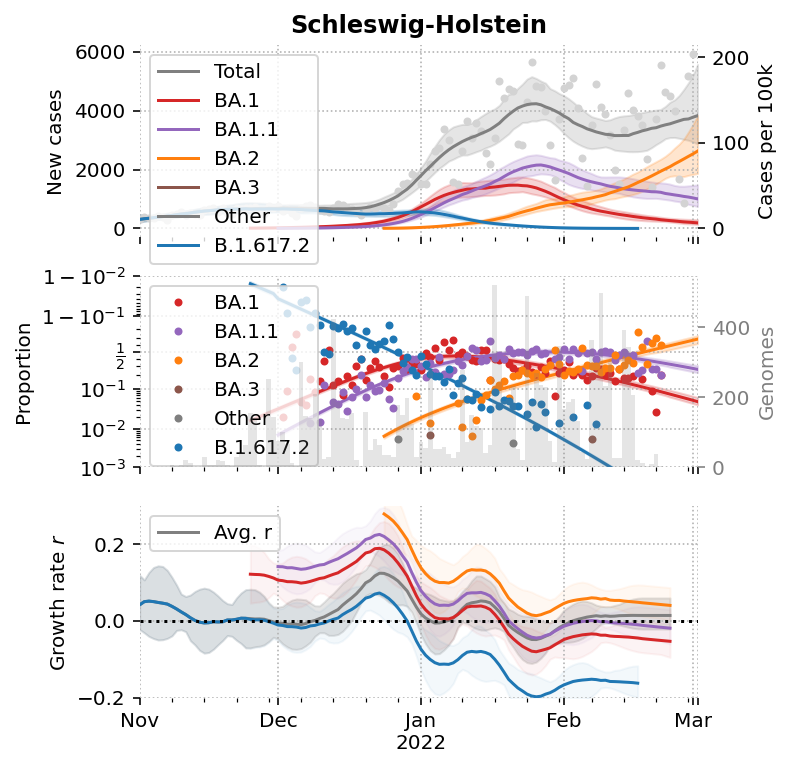

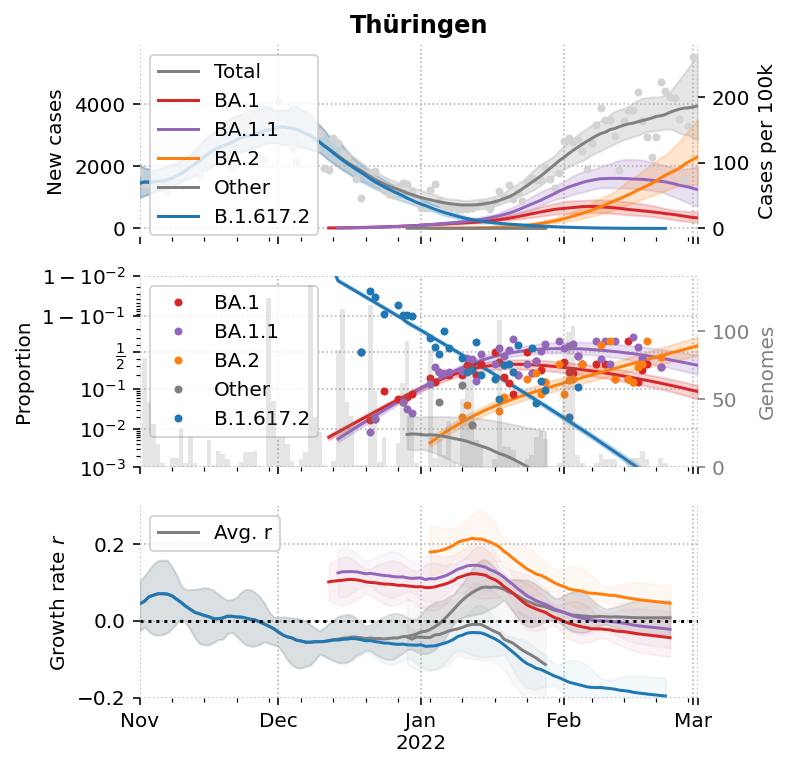

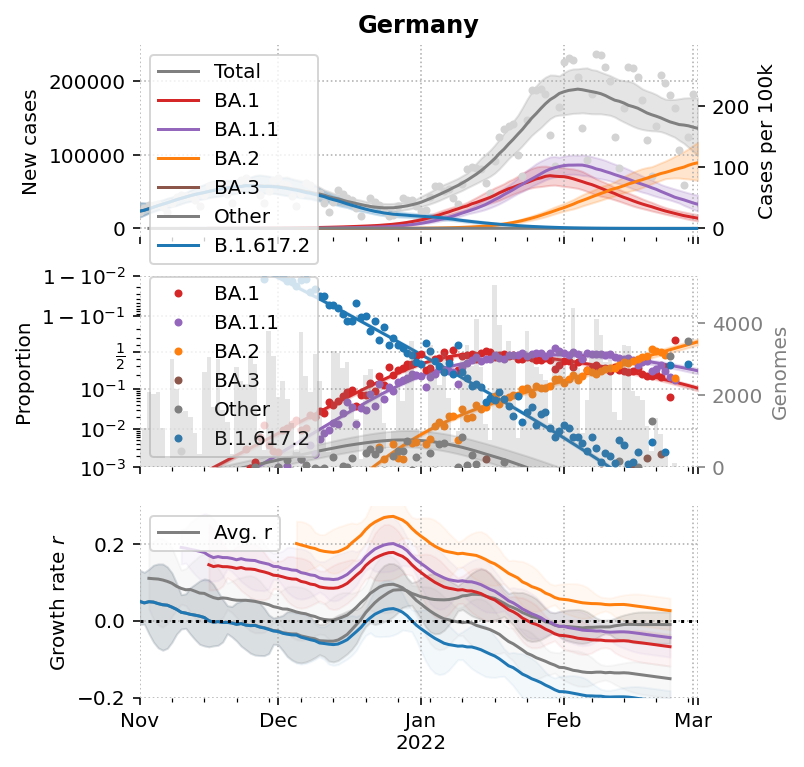

In [95]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C5","C7" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [96]:
genomes.sum(level=1).loc["2022-01-10":,:]

lineage     BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
date                                                  
2022-01-10  1368     906   100     0     19        747
2022-01-11  1551    1181    66     1      4        580
2022-01-12  1336    1087    58     1      6        331
2022-01-13  1663    1748   163     0      5        530
2022-01-14  1335    1039    88     0      0        313
2022-01-15   619     479    44     2      0         56
2022-01-16   381     303    39     0      0         45
2022-01-17  2167    2286   334     2      1        277
2022-01-18  1782    1645   173     0      1        336
2022-01-19  1407    1182   171     0      4        168
2022-01-20  1523    1620   219     0      2        130
2022-01-21  1454    1443   225     0      1         68
2022-01-22   329     378    60     0      0         57
2022-01-23   465     568   116     0      0         17
2022-01-24  1605    1686   385     0      0        102
2022-01-25  1341    1498   240     0      0        118
2022-01-26  1058    1360   326     0      0         34
2022-01-27   994    1245   275     0      0         63
2022-01-28  1019    1085   255     0      0         66
2022-01-29   475     597   141     0      0         13
2022-01-30   807    1692   515     0      0         19
2022-01-31  1009    1666   528     0      1         28
2022-02-01  1025    1366   386     0      0         36
2022-02-02   872    1101   396     0      0         25
2022-02-03  1271    2248   878     1      2         27
2022-02-04   998    1303   450     1      0         17
2022-02-05   380     378   180     0      0          4
2022-02-06   483     897   473     0      0          5
2022-02-07   909    1530   746     2      0         20
2022-02-08  1310    1925   852     3      0         13
2022-02-09  1001    1754   904     3      0          5
2022-02-10   820    1327   777     0      0          7
2022-02-11   740    1393   828     0      1          6
2022-02-12   446     657   431     1      0          2
2022-02-13   333     556   427     1      2          7
2022-02-14   815    1368  1191     0      0         13
2022-02-15   781    1394  1172     2      0          4
2022-02-16   528     800   782     2      0          3
2022-02-17   544     642   795     0      2          5
2022-02-18   404     674   793     1      0          0
2022-02-19   216     425   497     2      0          0
2022-02-20    86     108   242     0      7          2
2022-02-21   291     367   700     0      0          1
2022-02-22   168     289   454     2      0          0
2022-02-23   114      95   180     0      0          1
2022-02-24     1       3     0     0      7          5
2022-02-25    82      19    21     0      0          0
2022-02-28     0       0     0     0      2          1

In [97]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0000000000000002

In [98]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

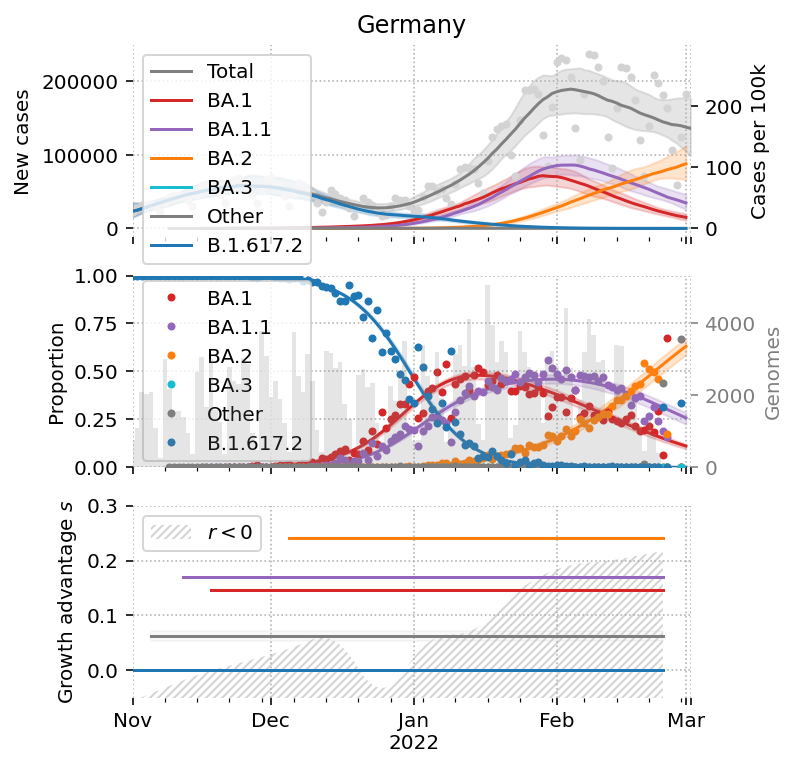

In [99]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [100]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [101]:
λ.shape

(17, 122, 6)

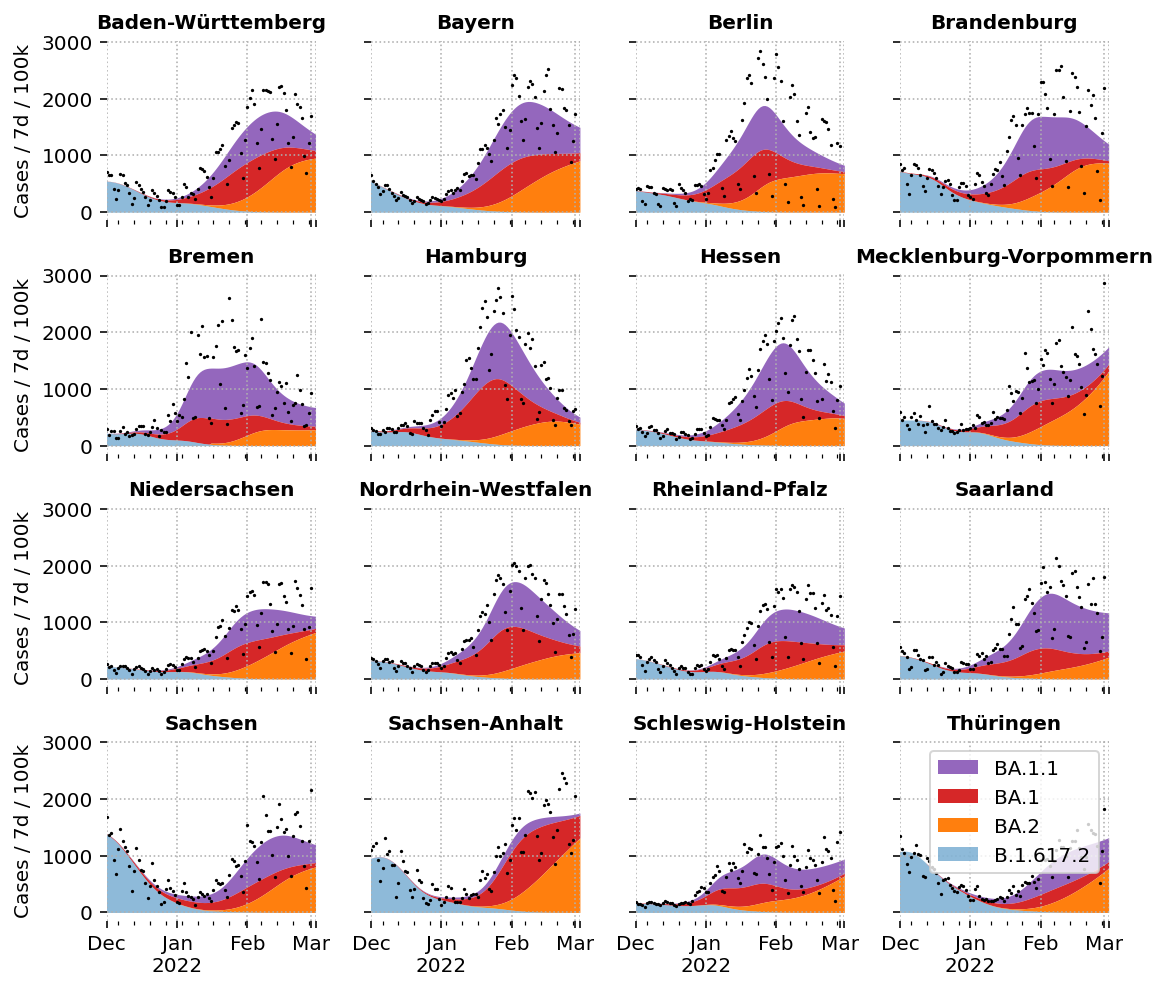

In [102]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [103]:
λ[-1,-1] / λ[-1,-1].sum()

array([1.03602769e-01, 2.46069353e-01, 6.47906717e-01, 2.38572145e-03,
       1.24619255e-05, 2.29767671e-05])

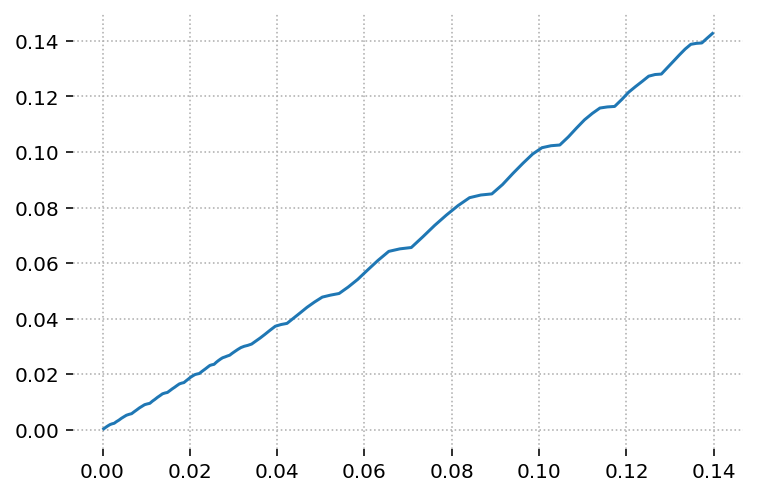

In [104]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [51]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

NameError: name 'get_transmissibility' is not defined

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       106758                   0.074147  0.010329   
BA.1.1     112558                   0.089463  0.012572   
BA.2        38620                   0.154627  0.008339   
BA.3           62                  -0.112713  0.033628   
Other         418                   0.039866  0.022414   
B.1.617.2  237624                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.010329  
BA.1.1                           0.025024  0.012572  
BA.2                             0.094951  0.008339  
BA.3                            -0.274022  0.033628  
Other                           -0.106414  0.022414  
B.1.617.2                       -0.144640  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


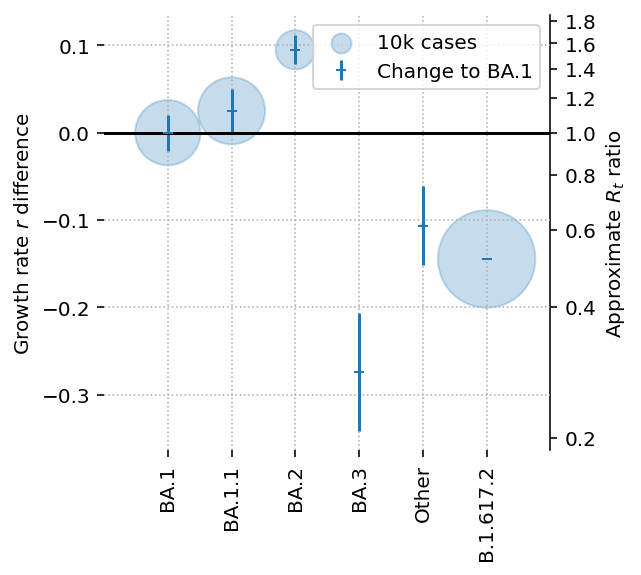

In [105]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [106]:
import geopandas as gpd

In [107]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [108]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [109]:
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-02-22     2       2     3     0      0          0
                  2022-02-23     0       0     3     0      0          0
                  2022-02-24     0       0     0     0      0          0
                  2022-02-25     0       0     0     0      0          0
                  2022-02-28     0       0     0     0      0          0

[1888 rows x 6 columns]

In [110]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([9.33537977e-02, 2.55209272e-01, 6.44443522e-01, 4.79755124e-03,
       2.16392804e-03, 3.19285239e-05])

In [111]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


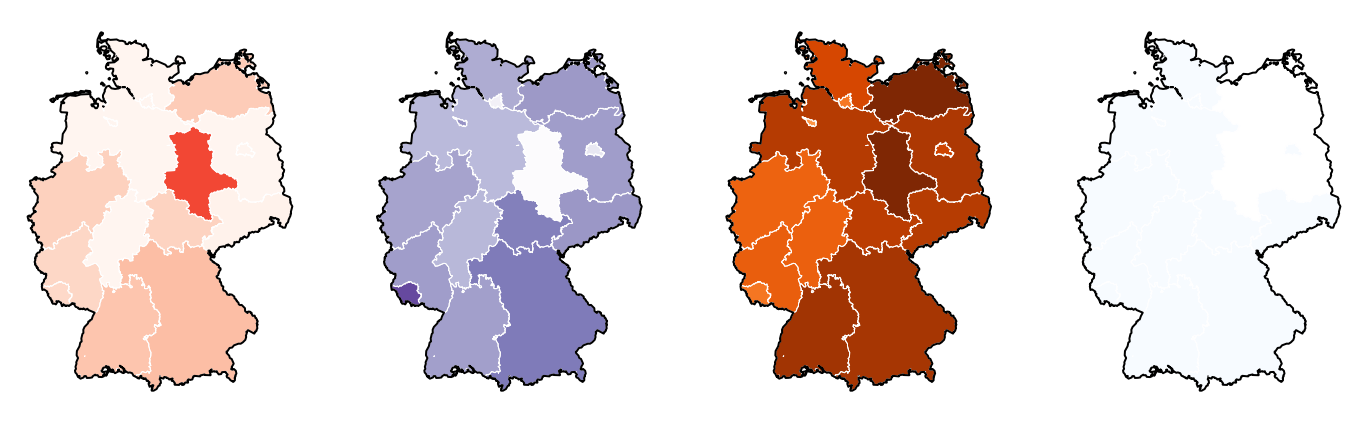

In [112]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [113]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1       BA.1.1          BA.2        BA.3  \
bundesland                                                                   
Baden-Württemberg       2102.532669  4589.826515  15128.939649    0.008881   
Bayern                  2671.598575  8398.040993  17021.311450    0.000000   
Berlin                   185.044318   596.023115   3553.640118    0.000000   
Brandenburg              155.933454  1064.293644   3121.181713   56.250479   
Bremen                    60.942225   319.769693    271.763739    0.000000   
Hamburg                   89.069160   244.587394    997.644046   28.701749   
Hessen                   436.495774  1990.864885   4318.704790   86.099782   
Mecklenburg-Vorpommern   282.626347   707.116054   3015.531751    0.000000   
Niedersachsen            808.255678  2463.698855   9389.595756    0.000000   
Nordrhein-Westfalen     3009.888266  7030.885599  11885.691886  758.349714   
Rheinland-Pfalz          654.816369  1732.707314   2883.723841    0.000000   
Saarland                 152.920962   947.279560    541.175040    0.000000   
Sachsen                  434.228264  1830.669936   4658.192565   65.328133   
Sachsen-Anhalt          1233.405711   135.254383   4096.201830   14.916956   
Schleswig-Holstein       196.289496  1049.047213   2678.297532   29.905960   
Thüringen                348.204947  1279.241818   2367.378592    0.000000   

                             Other  B.1.617.2  
bundesland                                     
Baden-Württemberg         1.271775   0.683564  
Bayern                    0.328699   0.314107  
Berlin                    0.030460   0.017323  
Brandenburg               0.000000   0.103281  
Bremen                    0.009941   0.002146  
Hamburg                   0.023898   0.021262  
Hessen                  369.241013   0.049592  
Mecklenburg-Vorpommern    0.000000   0.111119  
Niedersachsen             0.095331   0.329892  
Nordrhein-Westfalen       0.049171   0.347888  
Rheinland-Pfalz           0.022654   0.186662  
Saarland                  0.027135   0.036821  
Sachsen                   0.047034   0.122909  
Sachsen-Anhalt            0.000000   0.572620  
Schleswig-Holstein        0.024924   0.130019  
Thüringen                 0.172142   0.274297

In [114]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-0.08753581, -0.06300429,  0.00729014, -0.40489997, -0.22057304,
        -0.23693243],
       [-0.07112705, -0.0475447 ,  0.01497061, -0.22629302, -0.16180528,
        -0.22629302],
       [-0.09734462, -0.06965318, -0.00455828, -0.2439831 , -0.21796379,
        -0.2439831 ],
       [-0.1105809 , -0.07398081, -0.00419169, -0.36987403, -0.24265541,
        -0.24265541],
       [-0.10878139, -0.08726236, -0.02712584, -0.26552827, -0.20417776,
        -0.26552827],
       [-0.14598971, -0.11791104, -0.02767044, -0.47089546, -0.20839919,
        -0.27217258],
       [-0.10123192, -0.07377093, -0.00237299, -0.40054675, -0.18863544,
        -0.24664362],
       [-0.0477117 , -0.02188989,  0.04344566, -0.20013456, -0.20013456,
        -0.20013456],
       [-0.08362035, -0.05563634,  0.01805549, -0.2254153 , -0.17976696,
        -0.2254153 ],
       [-0.1009431 , -0.07444154, -0.00798242, -0.36853924, -0.20777606,
        -0.25245247],
       [-0.07635281, -0.04421093,  0.02026027, -0.

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


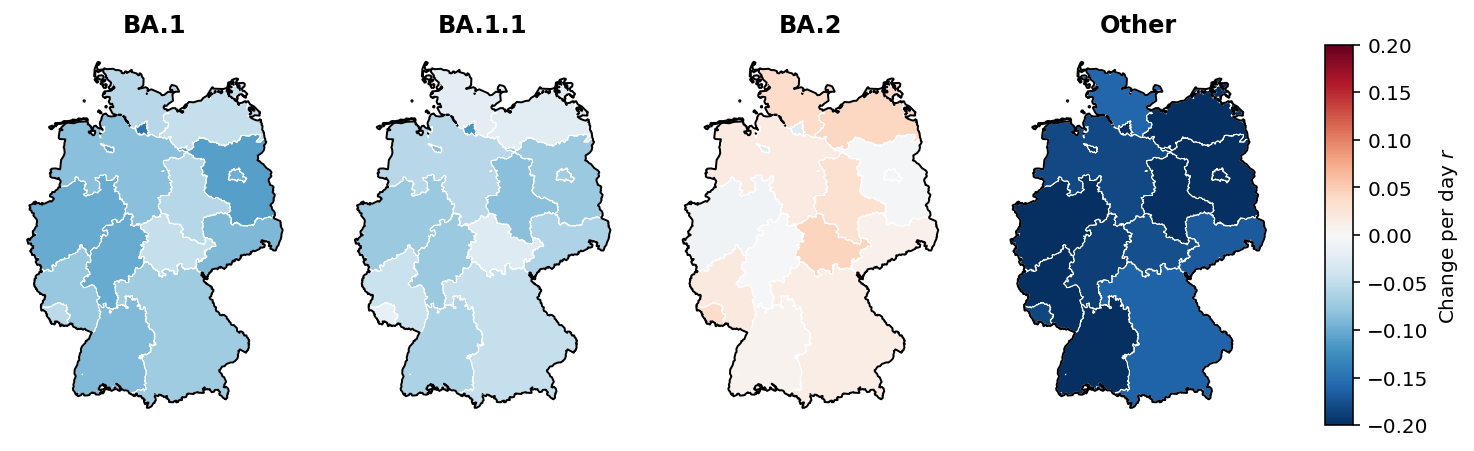

In [115]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [63]:
d

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
bundesland                                                                 
Baden-Württemberg      -0.084719 -0.060188  0.010107 -0.402084 -0.217757   
Bayern                 -0.059186 -0.035604  0.026912 -0.214352 -0.149864   
Berlin                 -0.089658 -0.061966  0.003129 -0.236296 -0.210277   
Brandenburg            -0.101502 -0.064902  0.004887 -0.360795 -0.233576   
Bremen                 -0.106357 -0.084838 -0.024702 -0.263104 -0.201754   
Hamburg                -0.139936 -0.111857 -0.021617 -0.464842 -0.202346   
Hessen                 -0.096900 -0.069439  0.001959 -0.396215 -0.184303   
Mecklenburg-Vorpommern -0.036745 -0.010923  0.054413 -0.189168 -0.189168   
Niedersachsen          -0.073759 -0.045775  0.027917 -0.215554 -0.169905   
Nordrhein-Westfalen    -0.091970 -0.065469  0.000991 -0.359566 -0.198803   
Rheinland-Pfalz        -0.069329 -0.037187  0.027284 -0.215255 -0.199943   
Saarland               -0.046754 -0.009494  0.045159 -0.188243 -0.174214   
Sachsen                -0.087195 -0.057927  0.013162 -0.411362 -0.165505   
Sachsen-Anhalt         -0.054759 -0.080929  0.033862 -0.346052 -0.210339   
Schleswig-Holstein     -0.045088 -0.009830  0.049158 -0.293092 -0.148532   
Thüringen              -0.038966 -0.017131  0.052264 -0.192006 -0.168274   

lineage                 B.1.617.2  
bundesland                         
Baden-Württemberg       -0.234116  
Bayern                  -0.214352  
Berlin                  -0.236296  
Brandenburg             -0.233576  
Bremen                  -0.263104  
Hamburg                 -0.266119  
Hessen                  -0.242311  
Mecklenburg-Vorpommern  -0.189168  
Niedersachsen           -0.215554  
Nordrhein-Westfalen     -0.243479  
Rheinland-Pfalz         -0.215255  
Saarland                -0.188243  
Sachsen                 -0.230935  
Sachsen-Anhalt          -0.210339  
Schleswig-Holstein      -0.162778  
Thüringen               -0.192006

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


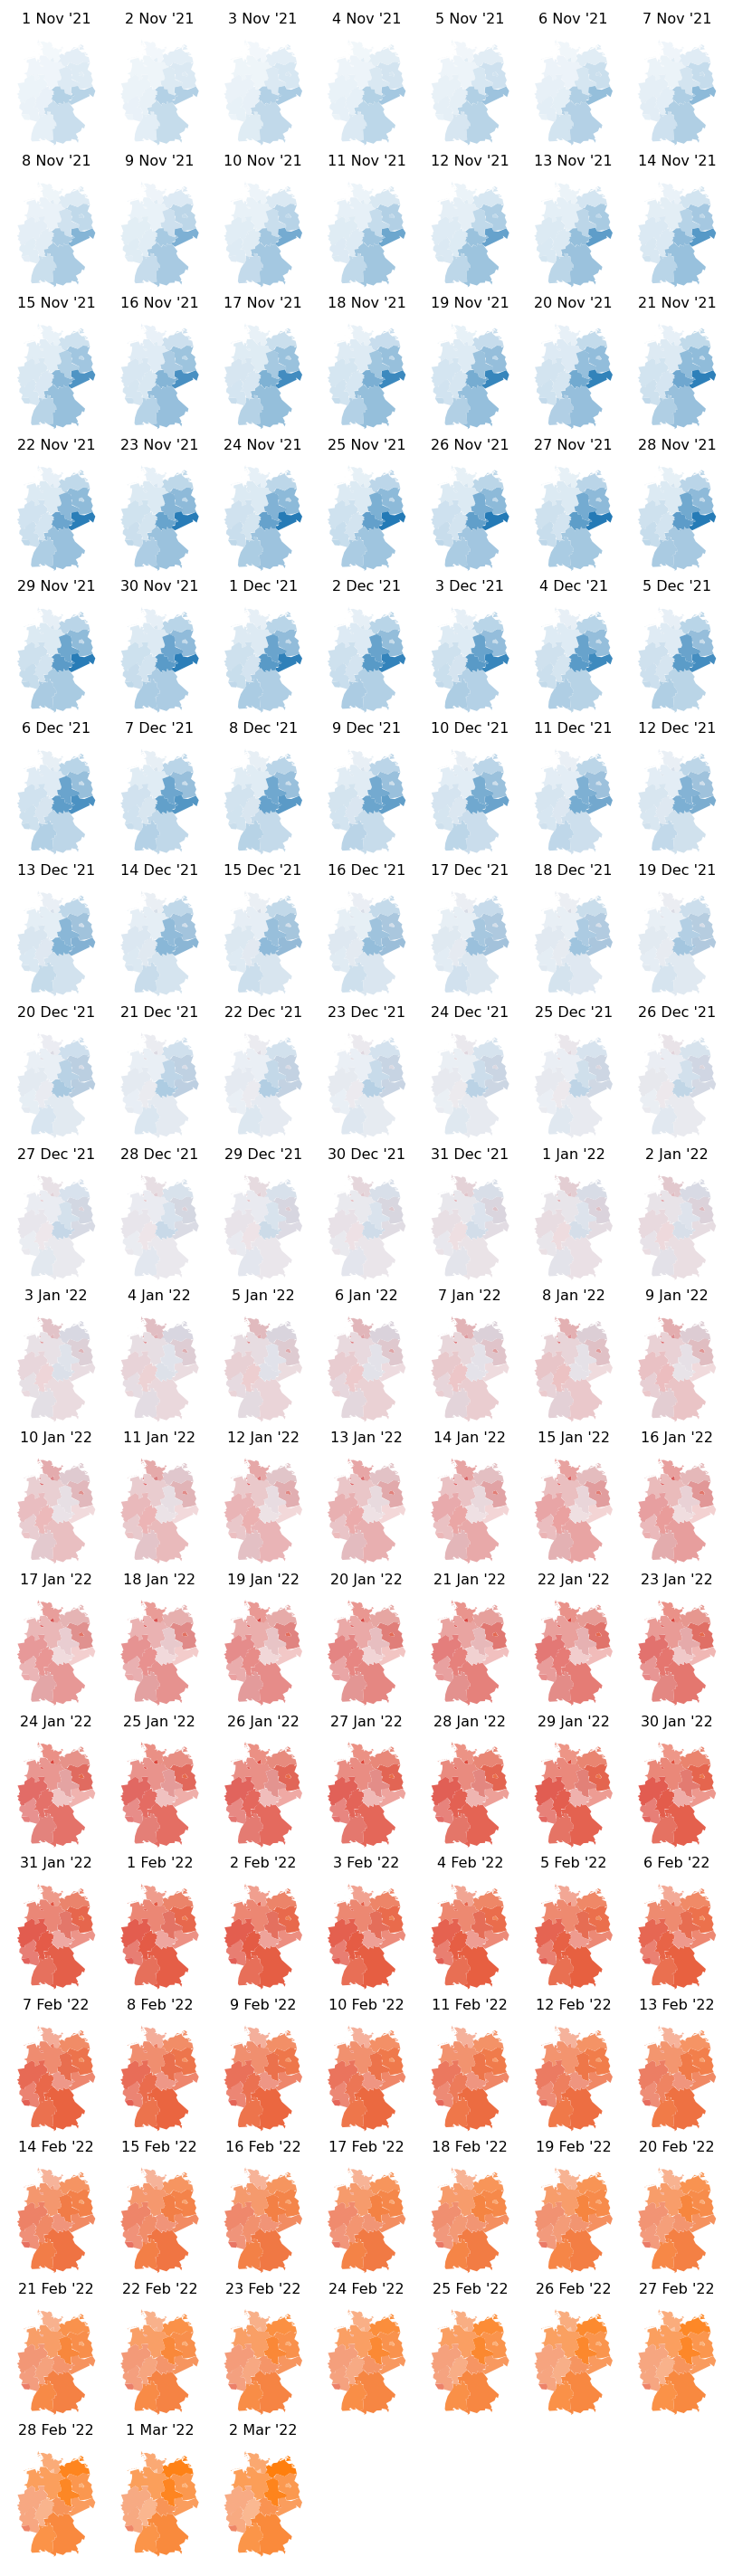

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


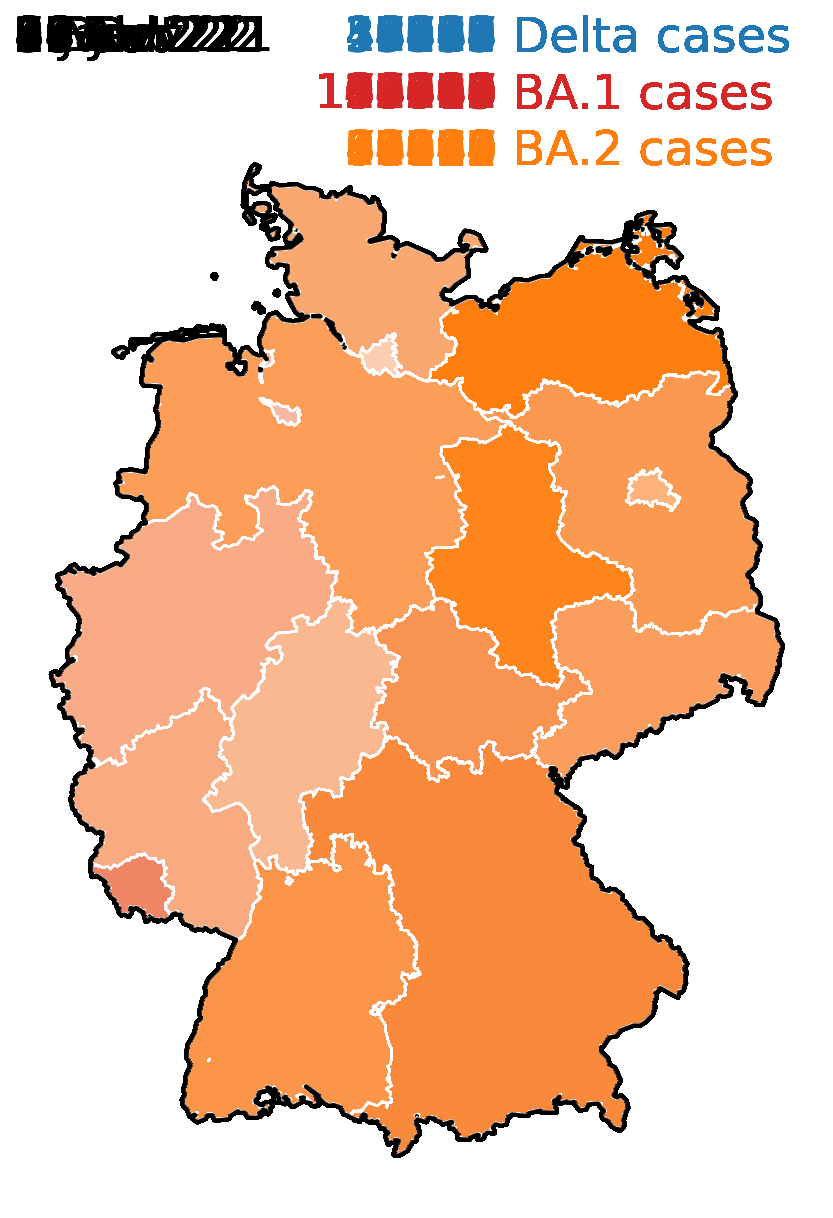

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

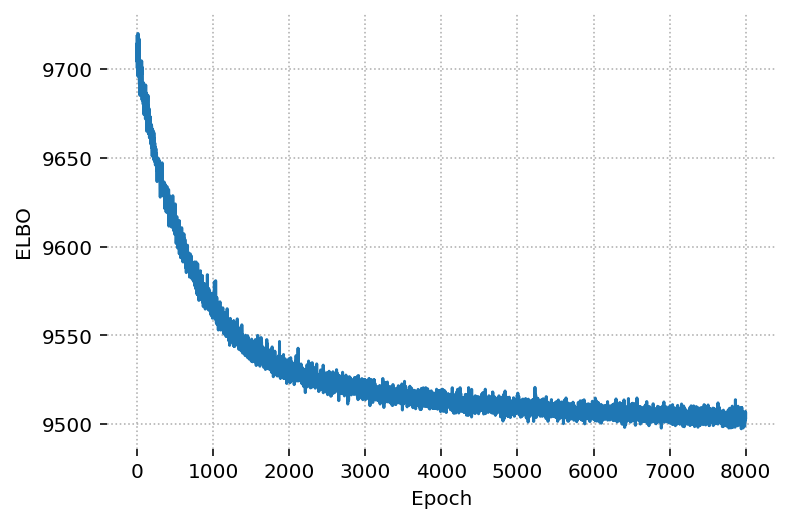

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

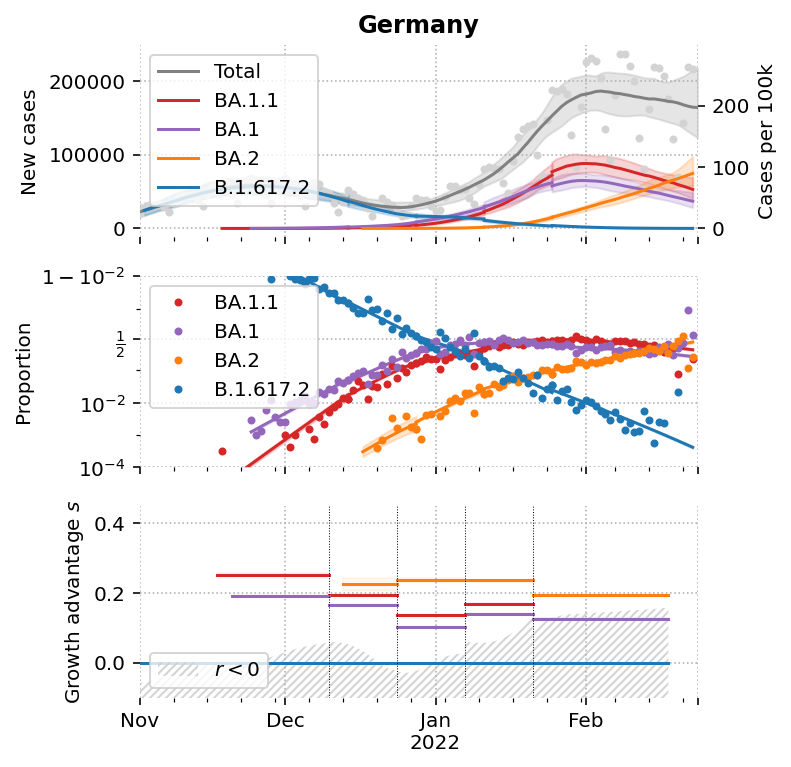

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


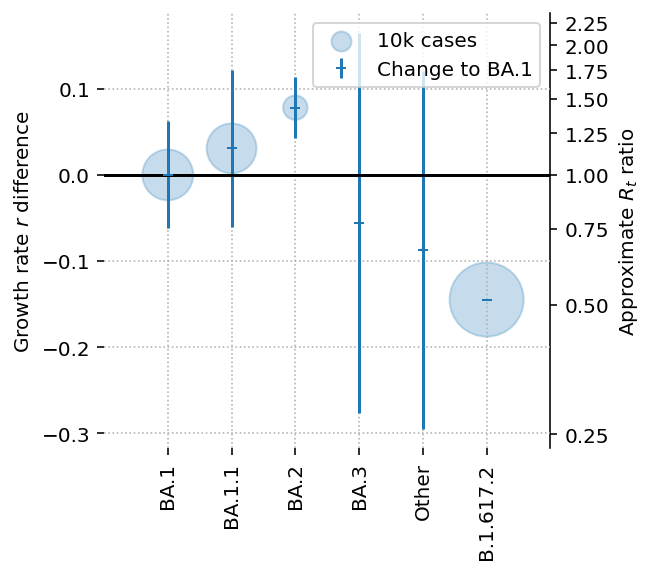

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
